In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| default_exp segment

In [3]:
#| export
import sys
sys.path.insert(0,'..')

from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import numpy as np
from mytools.tools import *
from urllib.request import urlopen
import cv2
from PIL import Image
from segmentor.paths import *
from pathlib import Path
import torch

def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	# return the image
	return image

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from mytools.visual import  *

In [5]:
#| export
#checkpoints_path = Path('/home/dima/FoodSeg103-Benchmark-v1/checkpoints/')
model_path = checkpoints_path.ls()[7]

# config_file     = [p for p in model_path.ls() if '.py' in p.name][0]
# checkpoint_file = [p for p in model_path.ls() if 'pth' in p.name][0]

# print(model_path)


In [6]:
# #export
# segment_model = init_segmentor(str(config_file), str(checkpoint_file), device='cuda:0')

In [7]:
# #export

# segment_model = segment_model

In [2]:
#| export
def get_segment_model(model_path, device = 'cuda:0'):
    config_file     = [p for p in model_path.ls() if '.py' in p.name][0]
    checkpoint_file = [p for p in model_path.ls() if 'pth' in p.name][0]
    return  init_segmentor(str(config_file), str(checkpoint_file), device=device)

inference_segmentor =inference_segmentor

    

NameError: name 'inference_segmentor' is not defined

In [3]:
!nbdev_export

In [13]:
# for model_path in checkpoints_path.ls():
#     try:
#         segment_model = get_segment_model(model_path)
#         print('OK', model_path)
#     except:
#         print('CURRUPTED', model_path)

In [12]:
# segment_model = get_segment_model(checkpoints_path.ls()[7])

In [10]:
photo_id=''

url = 'https://image.shutterstock.com/z/stock-photo-white-plate-of-orange-pumpkin-soup-on-the-table-studio-shot-1909804795.jpg'
img = get_image_from_url(url)
img = crop_image_to_square(img)
total_size = img.size[0]*img.size[1]

i = np.asarray(img, dtype="uint8")
i = np.flip(i,2)

In [11]:
segmentor_mask = inference_segmentor(segment_model, i)[0]

/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


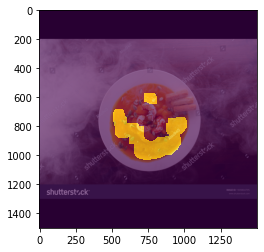

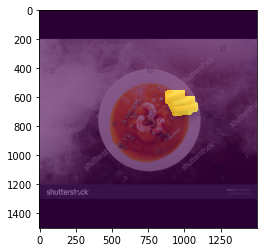

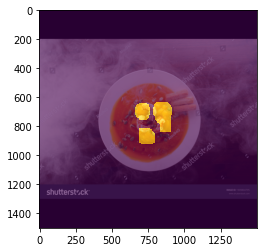

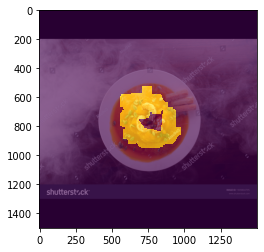

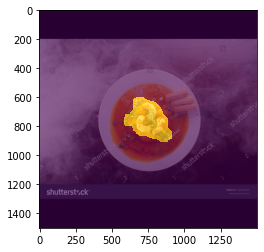

In [12]:
classes = np.unique(segmentor_mask)[1:]
classes_ =[]
urls = []
for c in classes:
    area = segmentor_mask[segmentor_mask==c].shape[0]
    if area> 100*100:
        class_mask = np.where(segmentor_mask==c,1,0)
        crop_mask = expand_boundaries(class_mask,times=5,factor=5)
        crop_mask = np.array(crop_mask)
        
        fname = f'{photo_id}_{c}.jpg'
        img_arr = apply_mask(img,crop_mask.T)
        img_arr[img_arr==[0,0,0]]=255 #replace black with while
        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.imshow(crop_mask, interpolation='none', alpha=0.6)

In [20]:
save_segments(img,photo_id='')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [73]:
[p.unlink() for p in fragment_reference_images_path.ls()]

[None, None, None]

In [20]:
reference_images_path

PosixPath('/home/dima/data/food/reference_images')